# DS 9000 Project

Dataset [here](https://www.kaggle.com/datasets/nasa/kepler-exoplanet-search-results)

In [1]:
%load_ext jupyter_black

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df = pd.read_csv("cumulative.csv")
df.head()

,rowid,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,1,10797460,K00752.01,Kepler-227 b,CONFIRMED,CANDIDATE,1.000,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,2,10797460,K00752.02,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,3,10811496,K00753.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,...,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,4,10848459,K00754.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,...,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,5,10854555,K00755.01,Kepler-664 b,CONFIRMED,CANDIDATE,1.000,0,0,0,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509


## Summary of Columns
There are 50 columns in the dataset:

### Object Identification Columns
- `kepid`: The target ID, from the Kepler Input Catalog
- `kepoi_name`: Number used to identify a KOI (Kepler Object of Interest-- object that has exhibited at least one transit-like sequence)
- `kepler_name`: Name given once an object has been confirmed as a planet

### Target Variable
- `koi_disposition`: The category of the KOI according to the literature. (CANDIDATE, FALSE POSITIVE, NOT DISPOSITIONED, CONFIRMED)

### Project Disposition Columns
These columns are the result of Kepler data analysis.
- `koi_pdisposition`: The disposition Kepler data analysis has towards the candidate. (FALSE_POSITIVE, NOT_DISPOSITIONED, CANDIDATE)
- `koi_score`: The confidence in the `koi_pdisposition`. For CANDIDATE, a higher value indicates more confidence in the classification, whereas for FALSE POSITIVE, a higher value indicates less confidence in the disposition. ([0,1])
- `koi_fpflag_nt`: Not transit-like flag. Set when light curve is not consistent with planetary transit. (0 or 1)  
- `koi_fpflag_ss`: Stellar eclipse flag. Set when a significant secondary event is observed which indicates the transit-like event is most likely caused by an eclipsing binary. (0 or 1)
- `koi_fpflag_co`: Centroid offset flag. Set when the source of the signal is from a nearby star (0 or 1).
- `koi_fpflag_ec`: Ephemeris match indicates contamination flag. Set when the KOI has the same period and epoch as another object and is judged to be the result of contamination. (0 or 1)

### Transit Properties
These are physical properties of the stellar transit observed by Kepler
- `koi_period`: Interval between consecutive planetary transits (in days)       
- `koi_period_err1`: Positive uncertainty on `koi_period`
- `koi_period_err2`: Negative uncertainty on `koi_period`
- `koi_time0bk`: Time corresponding to the centre of the first detected transit, minus a constant, in Barycentric Julian Day 
- `koi_time0bk_err1`: Positive uncertainty on `koi_time0bk`
- `koi_time0bk_err2`: Negative uncertainty on `koi_time0bk`
- `koi_impact`: The sky-projected distance between the centre of the stellar disk and the centre of the planet disk at conjunction, normalized by the stellar radius       
- `koi_impact_err1`: Positive uncertainty on `koi_impact`
- `koi_impact_err2`: Negative uncertainty on `koi_impact`
- `koi_duration`: Transit duration in hours.   
- `koi_duration_err1`: Positive uncertainty in transit duration.
- `koi_duration_err2`: Negative uncertainty in transit duration.
- `koi_depth`: The fraction of stellar flux lost at the minimum of planetary transit (ppm)
- `koi_depth_err1`: Positive uncertainty on `koi_depth`
- `koi_depth_err2`: Negative uncertainty on `koi_depth`
- `koi_prad`: Planetary radius (Earth radii)  
- `koi_prad_err1`: Positive uncertainty on `koi_prad`    
- `koi_prad_err2`: Negative uncertainty on `koi_prad`
- `koi_teq`: Approximation for temperature of the planet (Kelvin)
- `koi_teq_err1`: Positive uncertainty on `koi_teq`
- `koi_teq_err2`: Negative uncertainty on `koi_teq`
- `koi_insol`: Insolation flux (Earth flux)
- `koi_insol_err1`: Positive uncertainty on `koi_insol`
- `koi_insol_err2`: Negative uncertainty on `koi_insol`

### Threshold Crossing Event (TCE) Information
- `koi_model_snr`: Transit signal-to-noise ratio    
- `koi_tce_plnt_num`: TCE planet number federated to the KOI*
- `koi_tce_delivname`: TCE delivery name corresponding to the TCE data federated to the KOI*

### Stellar Parameters
- `koi_steff`: The photospheric temperature of the star (Kelvin)        
- `koi_steff_err1`: Positive uncertainty on `koi_steff`
- `koi_steff_err2`: Negative uncertainty on `koi_steff`
- `koi_slogg`: Base 10 logarithm of the star's surface gravity ($log_{10}(cm/s^2)$) 
- `koi_slogg_err1`: Positive uncertainty on `koi_slogg`
- `koi_slogg_err2`: Negative uncertainty on `koi_slogg`
- `koi_srad`: Stellar radius (solar radii)
- `koi_srad_err1`: Positive uncertainty on `koi_srad`
- `koi_srad_err2`: Negative uncertainty on `koi_srad`

### KIC Parameters
- `ra`: KIC Right Ascension (degrees)
- `dec`: KIC Declination (degrees)
- `koi_kepmag`: Kepler-band (magnitude)

We are interested only in parameters related to the physical properties of the transit. As such, we can drop the object identification columns, `koi_tce_plnt_num`, `koi_tce_delivname`, `ra`, and `dec`. We'll also drop `koi_pdisposition`, `koi_score`, and `koi_fpflag_nt`, as these are the product of Kepler's data analysis and not directly related to the physical properties of the transit. We'll keep the `koi_fpflag_ss`, `koi_fpflag_co`, `koi_fpflag_ec` as they describe properties of the light curve and their inclusion may improve model performance.

In [3]:
drop_cols = [
    "rowid",
    "kepid",
    "kepoi_name",
    "kepler_name",
    "koi_pdisposition",
    "koi_score",
    "koi_fpflag_nt",
    "koi_tce_plnt_num",
    "koi_tce_delivname",
    "ra",
    "dec",
]

df = df.drop(drop_cols, axis=1, errors="ignore")

# Basic info on data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9564 entries, 0 to 9563
Data columns (total 39 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   koi_disposition    9564 non-null   object 
 1   koi_fpflag_ss      9564 non-null   int64  
 2   koi_fpflag_co      9564 non-null   int64  
 3   koi_fpflag_ec      9564 non-null   int64  
 4   koi_period         9564 non-null   float64
 5   koi_period_err1    9110 non-null   float64
 6   koi_period_err2    9110 non-null   float64
 7   koi_time0bk        9564 non-null   float64
 8   koi_time0bk_err1   9110 non-null   float64
 9   koi_time0bk_err2   9110 non-null   float64
 10  koi_impact         9201 non-null   float64
 11  koi_impact_err1    9110 non-null   float64
 12  koi_impact_err2    9110 non-null   float64
 13  koi_duration       9564 non-null   float64
 14  koi_duration_err1  9110 non-null   float64
 15  koi_duration_err2  9110 non-null   float64
 16  koi_depth          9201 

From the output above, we can see that `koi_teq_err1` and `koi_teq_err2` are both empty columns. We'll drop those.

In [4]:
df = df.drop(["koi_teq_err1", "koi_teq_err2"], axis=1, errors="ignore")
df.head()

,koi_disposition,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,...,koi_steff,koi_steff_err1,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,koi_kepmag
0,CONFIRMED,0,0,0,9.488036,2.775000e-05,-2.775000e-05,170.538750,0.002160,-0.002160,...,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,15.347
1,CONFIRMED,0,0,0,54.418383,2.479000e-04,-2.479000e-04,162.513840,0.003520,-0.003520,...,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,15.347
2,FALSE POSITIVE,1,0,0,19.899140,1.494000e-05,-1.494000e-05,175.850252,0.000581,-0.000581,...,5853.0,158.0,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,15.436
3,FALSE POSITIVE,1,0,0,1.736952,2.630000e-07,-2.630000e-07,170.307565,0.000115,-0.000115,...,5805.0,157.0,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,15.597
4,CONFIRMED,0,0,0,2.525592,3.761000e-06,-3.761000e-06,171.595550,0.001130,-0.001130,...,6031.0,169.0,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,15.509


In [5]:
df["koi_disposition"].dropna().unique()

array(['CONFIRMED', 'FALSE POSITIVE', 'CANDIDATE'], dtype=object)

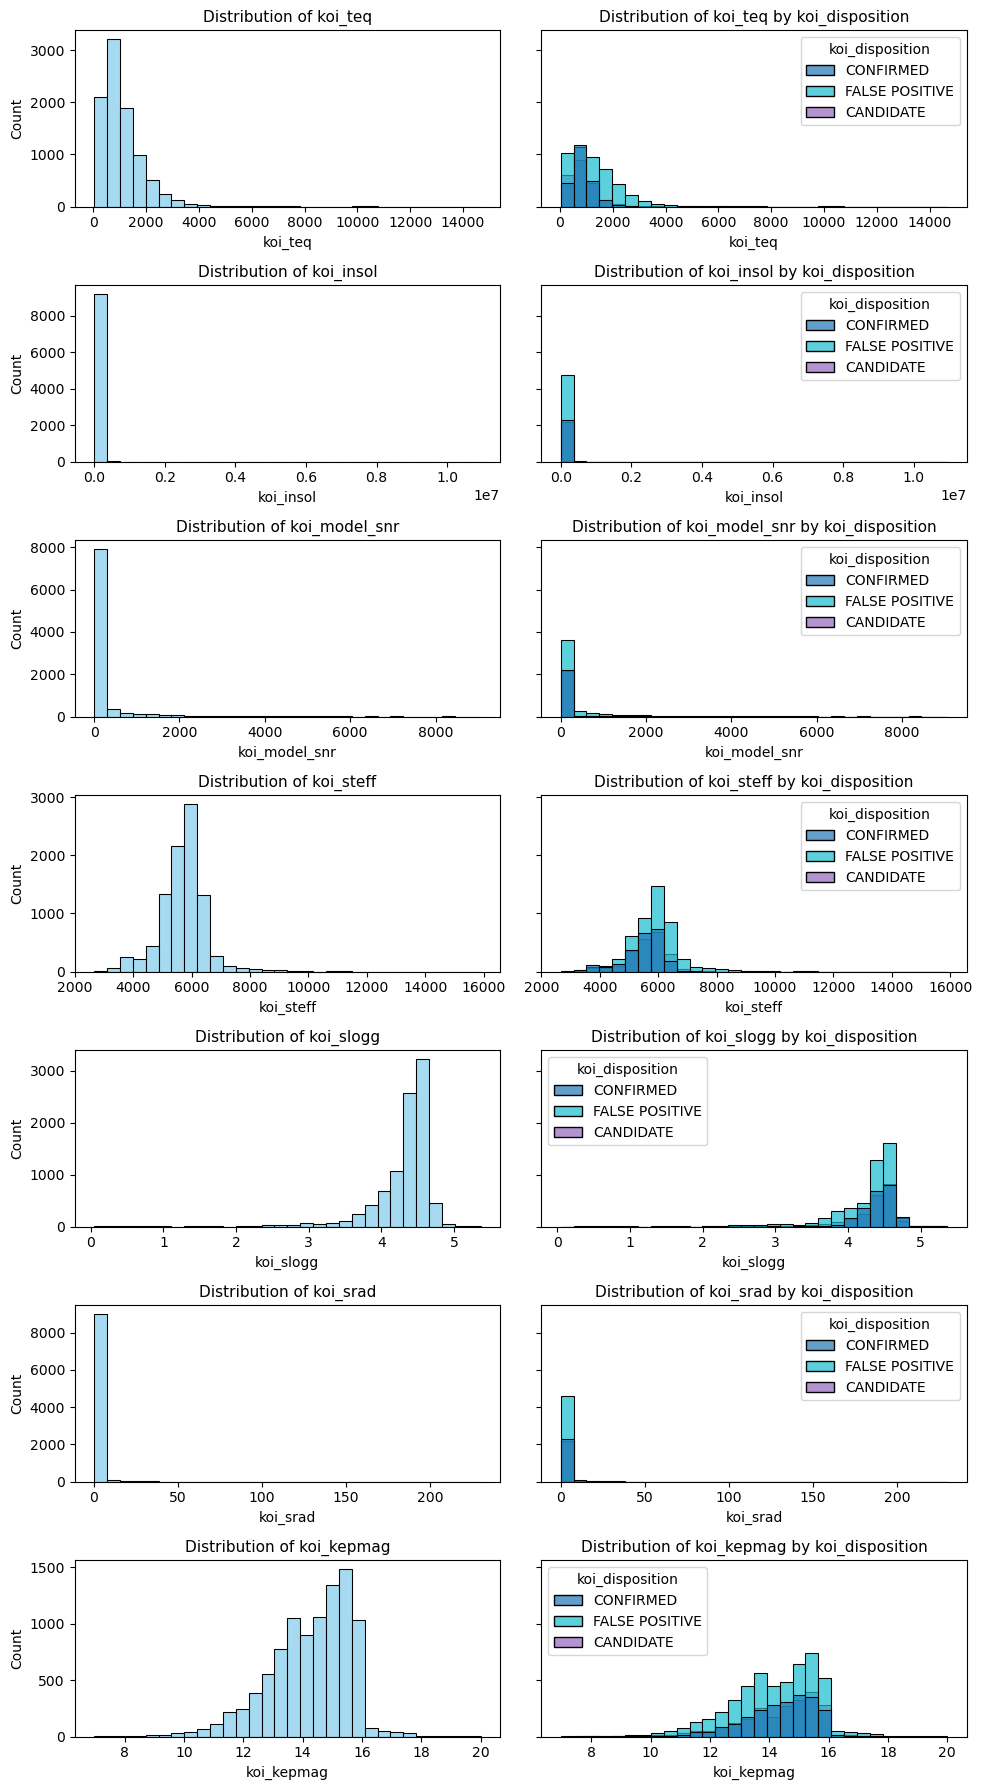

In [6]:
# column of interests
numerical_cols = [
    "koi_teq",
    "koi_insol",
    "koi_model_snr",
    "koi_steff",
    "koi_slogg",
    "koi_srad",
    "koi_kepmag",
]

# colors
palette = {"CONFIRMED": "#1f77b4", "FALSE POSITIVE": "#17becf", "CANDIDATE": "#9467bd"}

# 7 * 2 subplots
fig, axs = plt.subplots(
    nrows=len(numerical_cols), ncols=2, figsize=(10, 18), sharey="row"
)

for i, col in enumerate(numerical_cols):
    # first column - overall distribution
    sns.histplot(df, x=col, bins=30, ax=axs[i, 0], color="skyblue", edgecolor="black")
    axs[i, 0].set_title(f"Distribution of {col}", fontsize=11)
    axs[i, 0].set_xlabel(col)
    axs[i, 0].set_ylabel("Count")

    # second column - koi_disposition - ['CONFIRMED', 'FALSE POSITIVE', 'CANDIDATE']
    sns.histplot(
        df,
        x=col,
        hue="koi_disposition",
        bins=30,
        ax=axs[i, 1],
        alpha=0.7,
        palette=palette,
    )
    axs[i, 1].set_title(f"Distribution of {col} by koi_disposition", fontsize=11)
    axs[i, 1].set_xlabel(col)
    axs[i, 1].set_ylabel("Count")

plt.tight_layout()
plt.show()

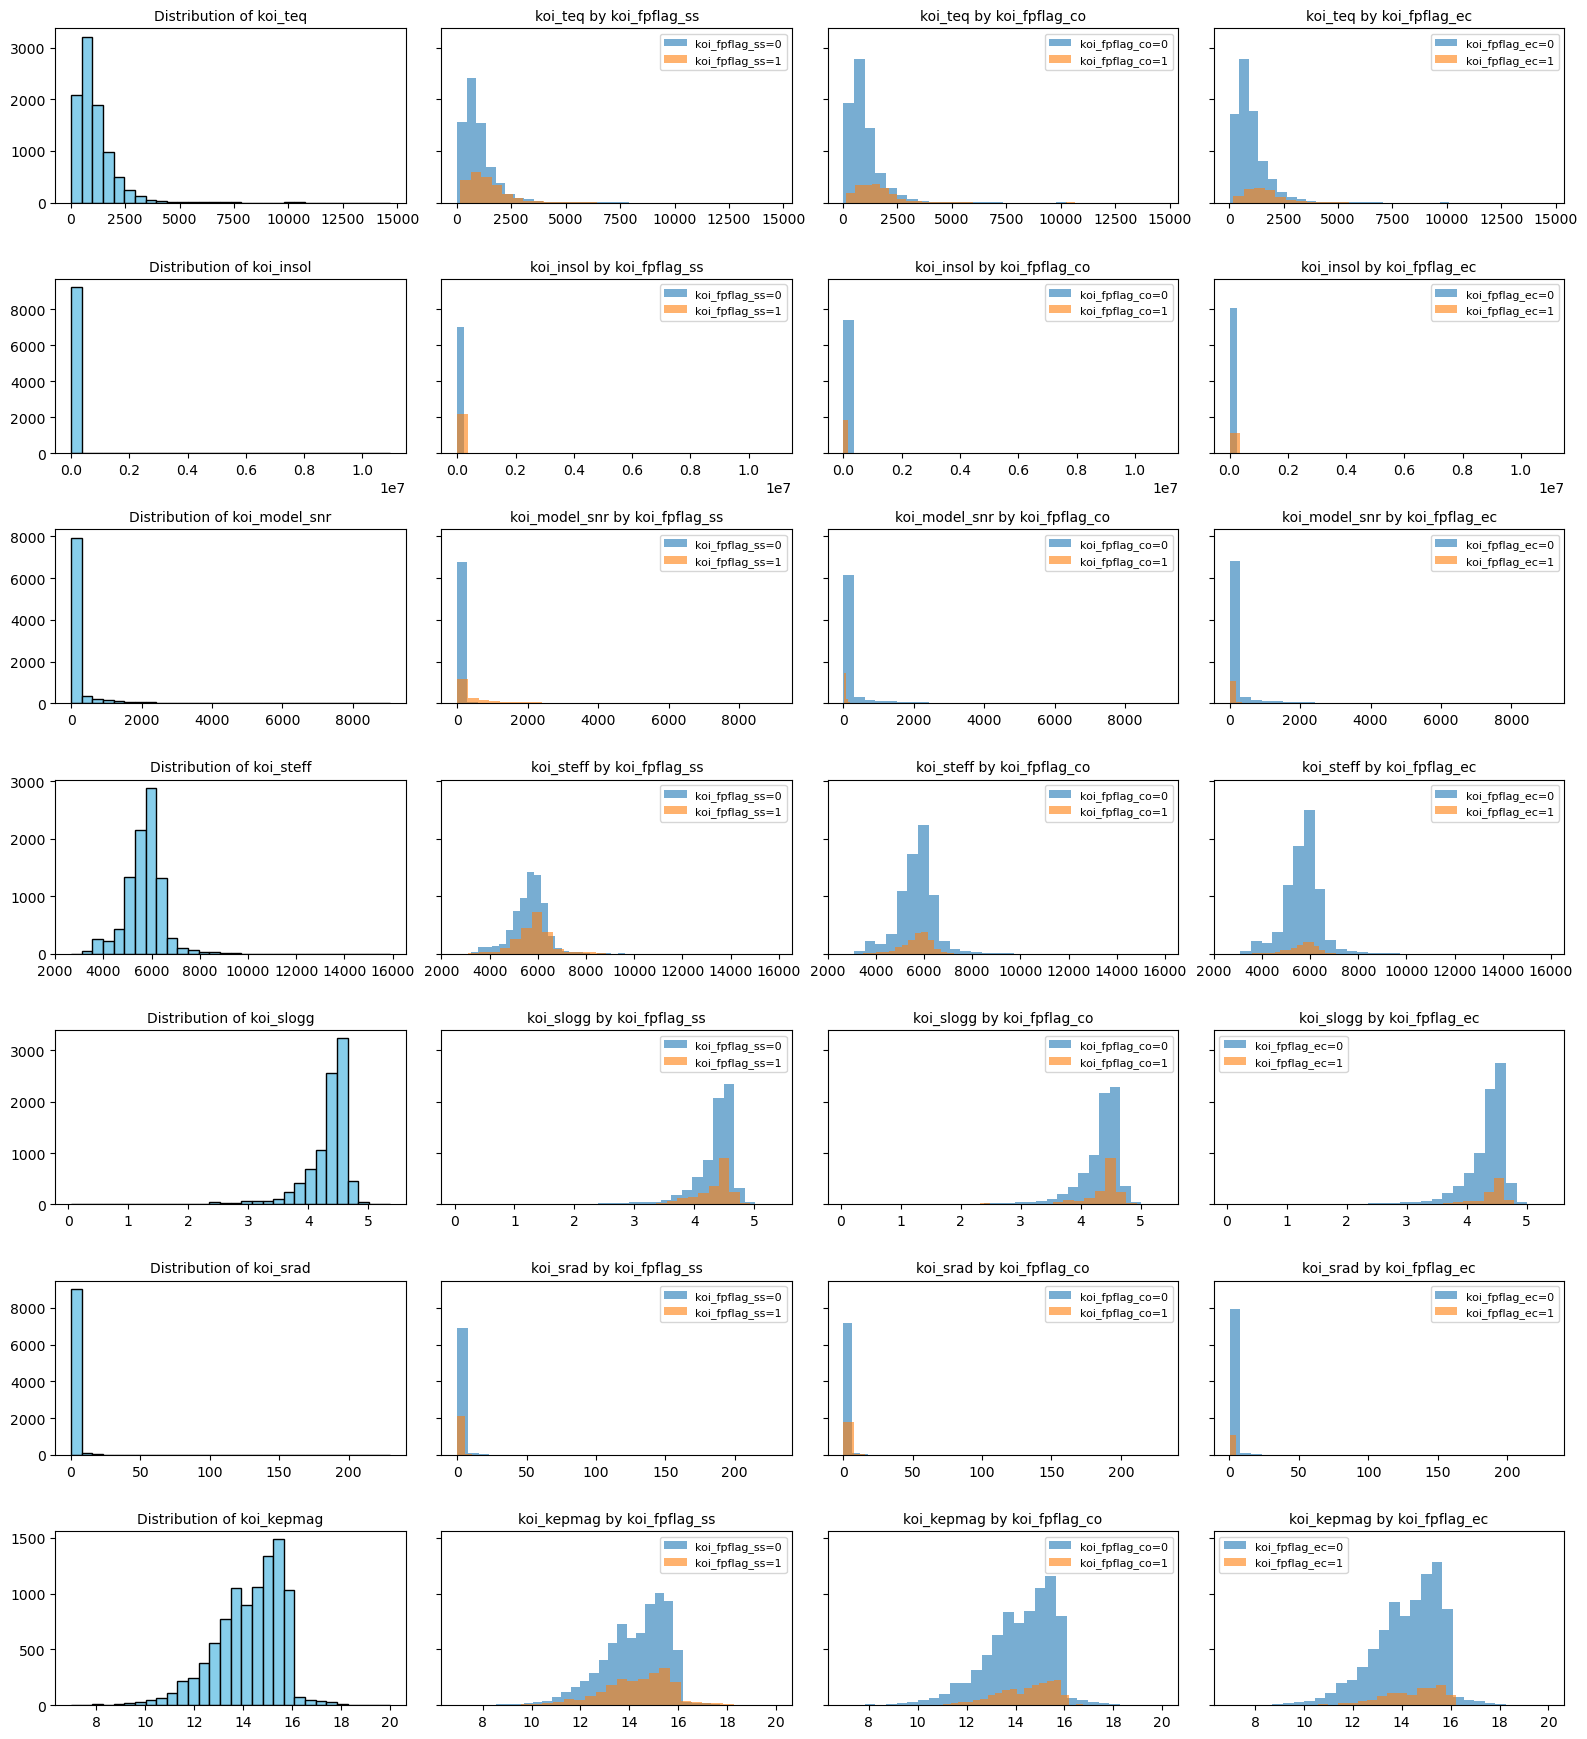

In [7]:
numerical_cols = [
    "koi_teq",
    "koi_insol",
    "koi_model_snr",
    "koi_steff",
    "koi_slogg",
    "koi_srad",
    "koi_kepmag",
]

flag_cols = ["koi_fpflag_ss", "koi_fpflag_co", "koi_fpflag_ec"]

# 7 rows × 4 columns
fig, axs = plt.subplots(
    nrows=len(numerical_cols),
    ncols=4,
    figsize=(16, 2.5 * len(numerical_cols)),
    sharey="row",
    squeeze=False,
)

for i, col in enumerate(numerical_cols):
    # first column - overall distribution
    ax = axs[i, 0]
    ax.hist(df[col].dropna(), bins=30, color="skyblue", edgecolor="black")
    ax.set_title(f"Distribution of {col}", fontsize=10)

    # column 2 - 4 - with flags
    for j, flag in enumerate(flag_cols, start=1):
        ax = axs[i, j]

        for val in sorted(df[flag].dropna().unique()):
            subset = df[df[flag] == val][col]
            ax.hist(subset, bins=30, alpha=0.6, label=f"{flag}={val}")
        ax.legend(fontsize=8)
        ax.set_title(f"{col} by {flag}", fontsize=10)

plt.tight_layout()

# plt.savefig("kepler_histograms_fast.png", dpi=150, bbox_inches="tight")
plt.show()

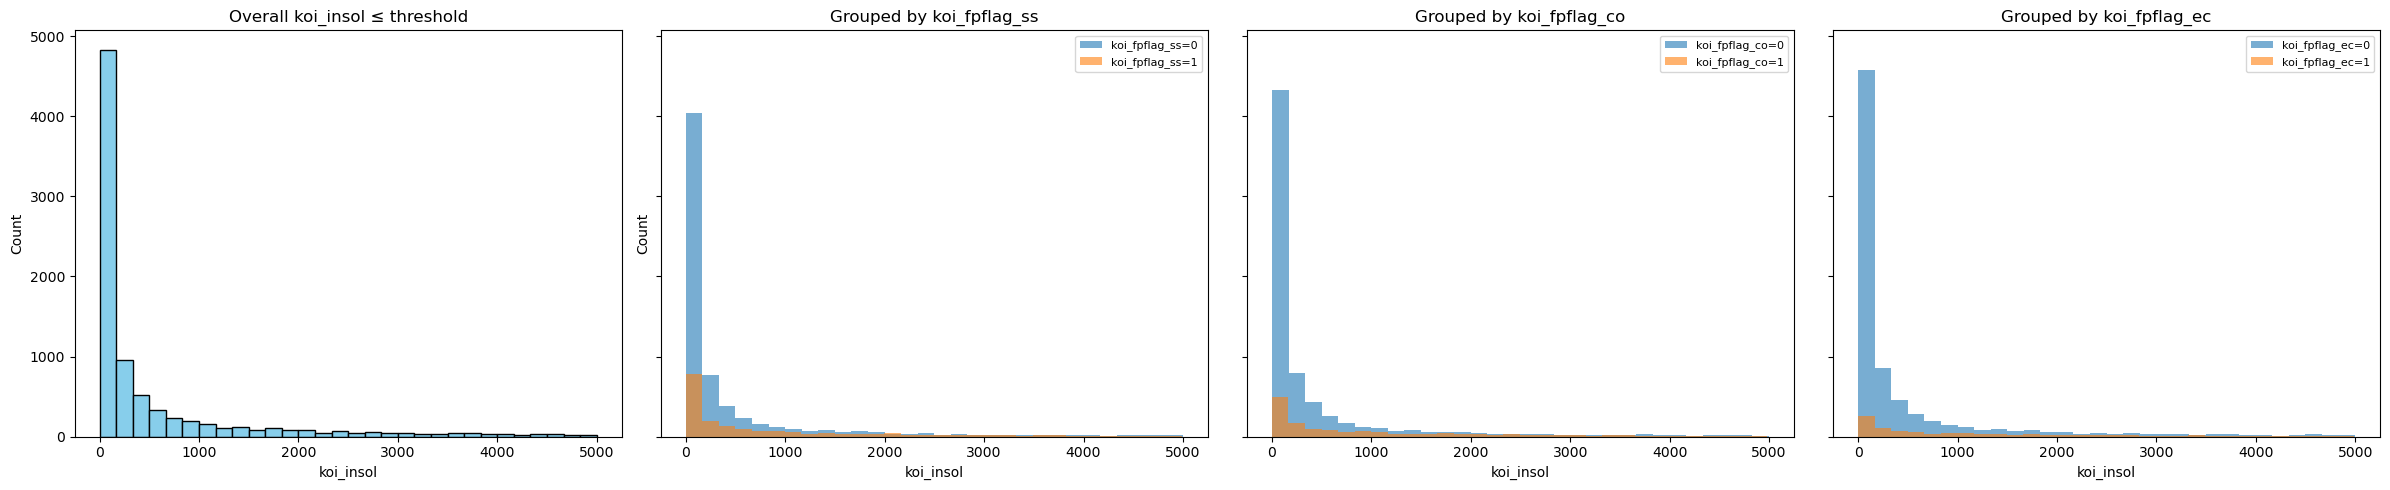

In [8]:
data = df["koi_insol"].dropna()
threshold = 0.005e6  # adjust as needed
subset = df[df["koi_insol"] <= threshold]

flag_cols = ["koi_fpflag_ss", "koi_fpflag_co", "koi_fpflag_ec"]

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(24, 5), sharey=True)

# first column - overall distribution
axs[0].hist(subset["koi_insol"], bins=30, color="skyblue", edgecolor="black")
axs[0].set_title("Overall koi_insol ≤ threshold")
axs[0].set_xlabel("koi_insol")
axs[0].set_ylabel("Count")

# column 2 - 4 - with flags
for j, flag in enumerate(flag_cols, start=1):
    ax = axs[j]
    for val in sorted(subset[flag].dropna().unique()):
        sub_flag = subset[subset[flag] == val]
        ax.hist(sub_flag["koi_insol"], bins=30, alpha=0.6, label=f"{flag}={val}")
    ax.set_title(f"Grouped by {flag}")
    ax.set_xlabel("koi_insol")
    if j == 1:
        ax.set_ylabel("Count")
    ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

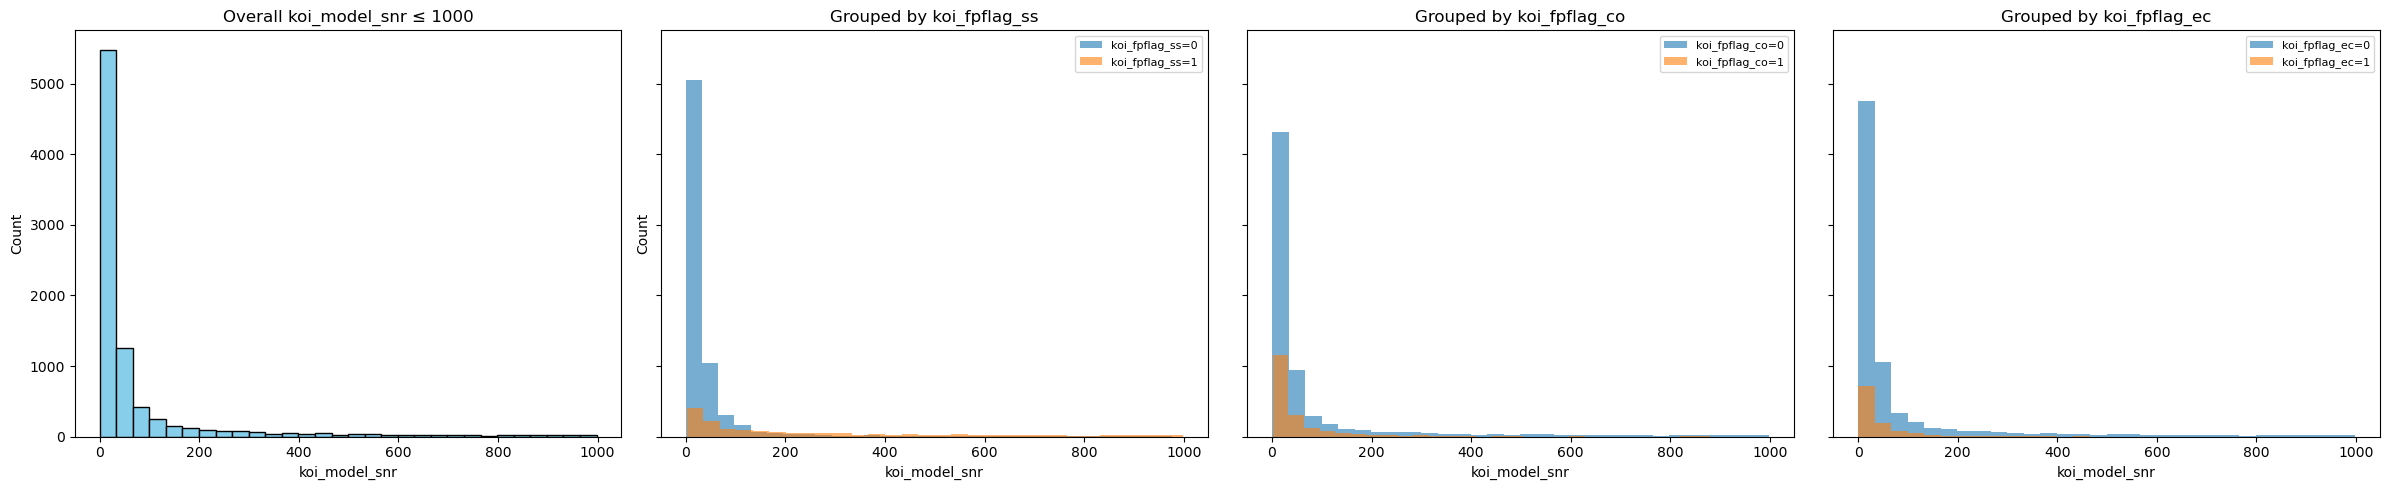

In [9]:
data = df["koi_model_snr"].dropna()
threshold = 1000
subset = df[df["koi_model_snr"] <= threshold]

flag_cols = ["koi_fpflag_ss", "koi_fpflag_co", "koi_fpflag_ec"]

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(24, 5), sharey=True)

# first column - overall distribution
axs[0].hist(subset["koi_model_snr"], bins=30, color="skyblue", edgecolor="black")
axs[0].set_title(f"Overall koi_model_snr ≤ {threshold}")
axs[0].set_xlabel("koi_model_snr")
axs[0].set_ylabel("Count")

# column 2 - 4 - with flags
for j, flag in enumerate(flag_cols, start=1):
    ax = axs[j]
    for val in subset[flag].dropna().unique():
        sub_flag = subset[subset[flag] == val]["koi_model_snr"]
        ax.hist(sub_flag, bins=30, alpha=0.6, label=f"{flag}={val}")
    ax.set_title(f"Grouped by {flag}")
    ax.set_xlabel("koi_model_snr")
    if j == 1:
        ax.set_ylabel("Count")
    ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

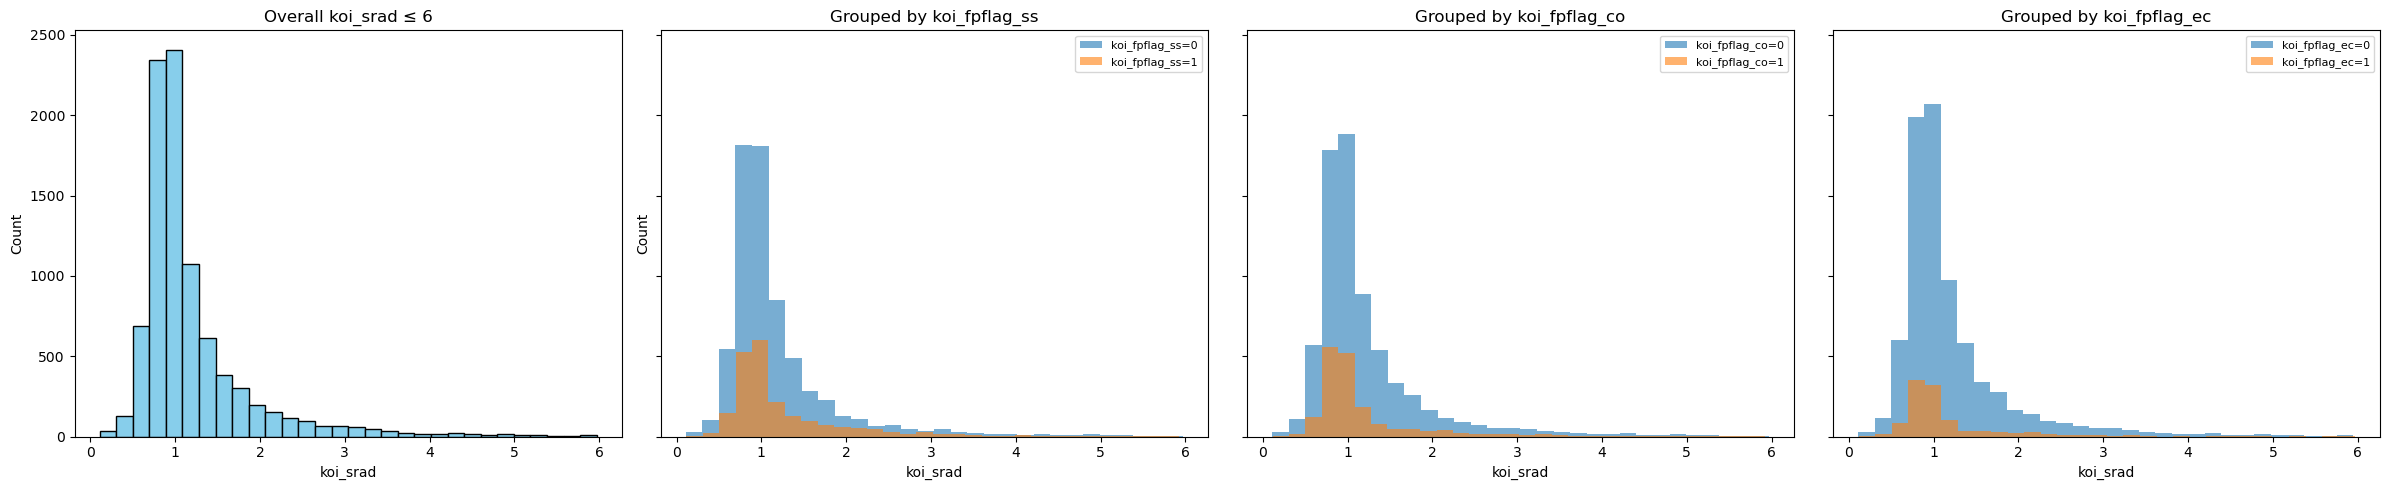

In [10]:
data = df["koi_srad"].dropna()
threshold = 6
subset = df[df["koi_srad"] <= threshold]

flag_cols = ["koi_fpflag_ss", "koi_fpflag_co", "koi_fpflag_ec"]

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(24, 5), sharey=True)

# first column - overall distribution
axs[0].hist(subset["koi_srad"], bins=30, color="skyblue", edgecolor="black")
axs[0].set_title(f"Overall koi_srad ≤ {threshold}")
axs[0].set_xlabel("koi_srad")
axs[0].set_ylabel("Count")

# column 2 - 4 - with flags
for j, flag in enumerate(flag_cols, start=1):
    ax = axs[j]
    for val in subset[flag].dropna().unique():
        sub_flag = subset[subset[flag] == val]["koi_srad"]
        ax.hist(sub_flag, bins=30, alpha=0.6, label=f"{flag}={val}")
    ax.set_title(f"Grouped by {flag}")
    ax.set_xlabel("koi_srad")
    if j == 1:
        ax.set_ylabel("Count")
    ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

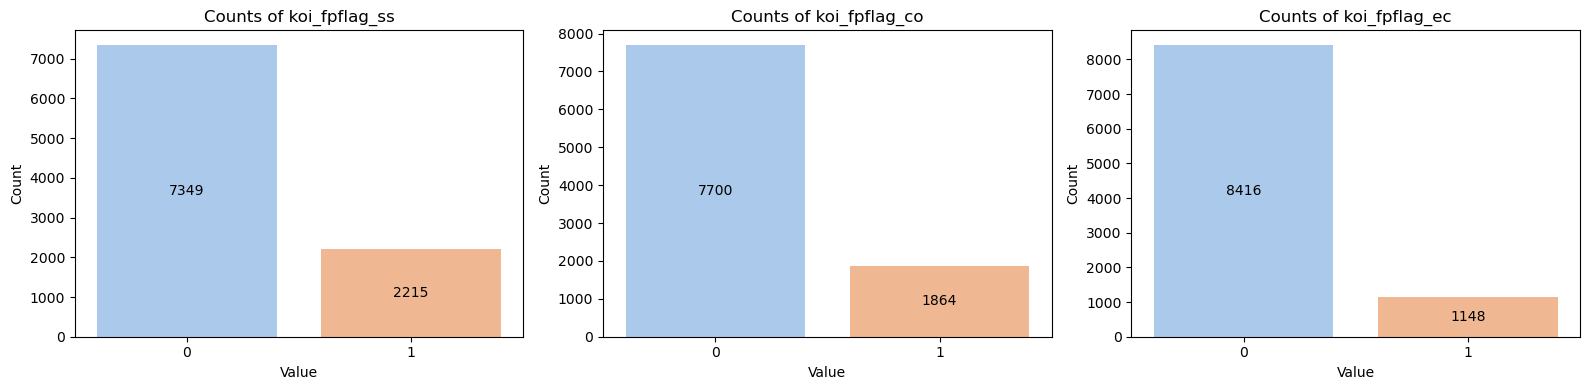

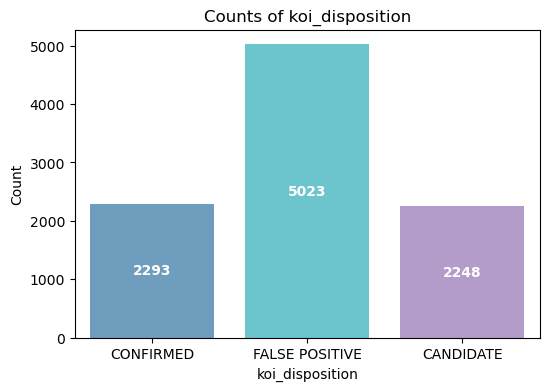

In [11]:
flag_cols = ["koi_fpflag_ss", "koi_fpflag_co", "koi_fpflag_ec"]
dispo_col = "koi_disposition"

# counts for flags
fig, axs = plt.subplots(1, len(flag_cols), figsize=(16, 4))
for i, col in enumerate(flag_cols):
    counts = df[col].value_counts().sort_index()
    sns.barplot(
        x=counts.index.astype(str), y=counts.values, ax=axs[i], palette="pastel"
    )
    axs[i].set_title(f"Counts of {col}")
    axs[i].set_xlabel("Value")
    axs[i].set_ylabel("Count")

    # Add counts inside bars
    for j, val in enumerate(counts.values):
        axs[i].text(
            j, val / 2, str(val), ha="center", va="center", fontsize=10, color="black"
        )

plt.tight_layout()
plt.show()

# counts for koi_disposition
plt.figure(figsize=(6, 4))
counts = (
    df[dispo_col].value_counts().reindex(["CONFIRMED", "FALSE POSITIVE", "CANDIDATE"])
)
sns.barplot(
    x=counts.index,
    y=counts.values,
    palette={
        "CONFIRMED": "#1f77b4",
        "FALSE POSITIVE": "#17becf",
        "CANDIDATE": "#9467bd",
    },
    alpha=0.7,
)

# Add counts inside bars
for j, val in enumerate(counts.values):
    plt.text(
        j,
        val / 2,
        str(val),
        ha="center",
        va="center",
        fontsize=10,
        color="white",
        fontweight="bold",
    )

plt.title("Counts of koi_disposition")
plt.xlabel("koi_disposition")
plt.ylabel("Count")
plt.show()